info: {'total_reward': 27.89616584777832, 'total_profit': 0.989812615901, 'position': <Positions.Long: 1>}


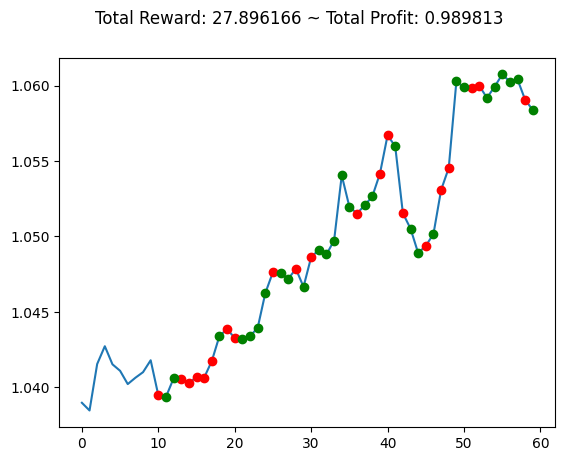

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL


env = gym.make('forex-v0', frame_bound=(50, 100), window_size=10)
# env = gym.make('stocks-v0', frame_bound=(50, 100), window_size=10)

observation = env.reset(seed=2023)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

In [9]:
import gymnasium as gym

from stable_baselines3 import DQN

env = gym.make("CartPole-v1", render_mode="human")

model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000, log_interval=4)
model.save("dqn_cartpole")

del model # remove to demonstrate saving and loading

model = DQN.load("dqn_cartpole")

obs, info = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        obs, info = env.reset()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.5     |
|    ep_rew_mean      | 24.5     |
|    exploration_rate | 0.907    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 39       |
|    time_elapsed     | 2        |
|    total_timesteps  | 98       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21       |
|    ep_rew_mean      | 21       |
|    exploration_rate | 0.84     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 38       |
|    time_elapsed     | 4        |
|    total_timesteps  | 168      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.473    |
|    n_updates        | 16       |
------------------------------

KeyboardInterrupt: 

: 